# Сталелитейная промышленность

<a id='section_1'></a>
## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «**Так закаляем сталь**» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет конечную температуру стали.
- **Целевой признак** - это последнее измерение _температуры_ партии из таблицы `data_temp_new.csv`
- Метрика: _МАЕ_ (mean_absolute_error)
- Значение: ± 6.8°C или меньше.

**Описание этапа обработки**

Сталь обрабатывают в _сталелитейном ковше_ вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. 

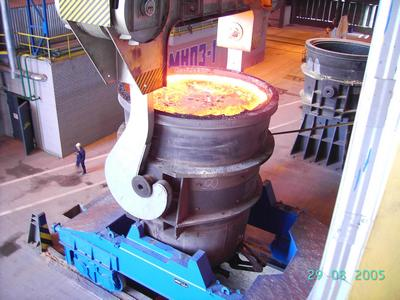

Расплавленную сталь заливают в ковш и подогревают до нужной температуры _графитовыми электродами_. Они установлены в крышке ковша.

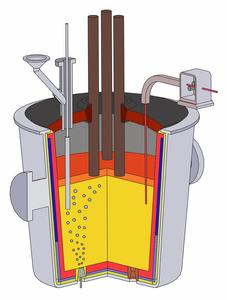

Из сплава выводится сера (процесс _десульфурации_), добавлением примесей корректируется химический состав и отбираются пробы. Сталь _легируют_ (изменяют её состав) — подавая куски сплава из бункера для сыпучих материалов или добавляя проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

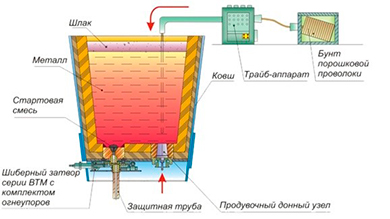

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

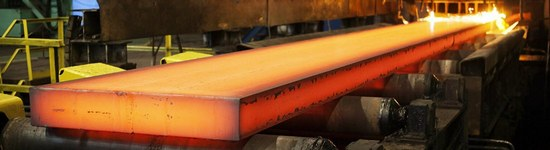

<a id='section_plan'></a>
**План проекта:**
1. [Описание проекта и тех. процесса](#section_1)
2. [Знакомство и предобработка данных](#section_2)
    1. [Подготовка](#section_2A)
    2. [Чтение данных](#section_2B)
    3. [Изменение типов данных](#section_2C)
    4. [Переименовывание столбцов](#section_2D)
    5. [Обработка пропусков](#section_2E)
3. [Анализ данных (EDA)](#section_3)
    1. [Временной период](#section_3A)
    2. [Время нагрева](#section_3B)
    2. [Мощность нагрева](#section_3C)
    4. [Температура сплава](#section_3D)
    5. [Инертный газ](#section_3E)
4. [Формирование (обуч. + тест.) выборок данных](#section_4)
    1. [Создание новых признаков](#section_4A)
    2. [Выделение признаков](#section_4B)
    3. [Анализ сформированной выборки](#section_4C)
    4. [Валидация данных](#section_4D)
5. [Обучение моделей](#section_5)
    1. [Линейная регрессия (LR)](#section_5A)
    2. [Случайный лес (RF)](#section_5B)
    3. [CatBoost (CB)](#section_5C)
    4. [Проверка моделей на адекватность](#section_5D)
6. [Итоговое тестирование](#section_6)
7. [Итоговый вывод (отчёт)](#section_7)
8. [Список вопросов для заказчика](#section_8)

___
<a id='section_2'></a>
## Чтение и знакомство с данными

<a id='section_2A'></a>
### Подготовка

In [1]:
# импорт основных библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# импорт спец. библиотек
import os
from tqdm.notebook import tqdm
from datetime import datetime
from catboost import CatBoostRegressor
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# импорт элементов библиотеки SKLEARN
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# константы
RANDOM_STATE = 150523

# адреса расположения датасета
HOME_PATH = 'datasets/'
SERVE_PATH = '/datasets/'

# названия файлов датасетов
FILE_NAMES = ['data_arc_new.csv',
              'data_bulk_new.csv',
              'data_bulk_time_new.csv',
              'data_gas_new.csv',
              'data_temp_new.csv',
              'data_wire_new.csv',
              'data_wire_time_new.csv']

<a id='section_2B'></a>
### Чтение данных

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные о времени и количестве нагрева полученные с _графитовых электродов_ [(source)](https://code.s3.yandex.net/datasets/data_arc_new.csv);
- `data_bulk_new.csv` — данные об объёме подаче сыпучих легирующих присадок [(source)](https://code.s3.yandex.net/datasets/data_bulk_new.csv);
- `data_bulk_time_new.csv` — данные о времени подаче сыпучих легирующих присадок [(source)](https://code.s3.yandex.net/datasets/data_bulk_time_new.csv);
- `data_gas_new.csv` — данные о продувке сплава _инертным газом_ [(source)](https://code.s3.yandex.net/datasets/data_gas_new.csv);
- `data_temp_new.csv` — результаты измерения температуры сплава [(source)](https://code.s3.yandex.net/datasets/data_temp_new.csv);
- `data_wire_new.csv` — данные об объёме проволочных легирующих присадок [(source)](https://code.s3.yandex.net/datasets/data_wire_new.csv);
- `data_wire_time_new.csv` — данные о времени проволочных легирующих присадок [(source)](https://code.s3.yandex.net/datasets/data_wire_time_new.csv).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Пояснение:**

Большинство колонок имеет русскоязычное наименование, чего достаточно для понимания какие данные содержаться в них. Но не во всех. Для некоторых датасетов приведу пояснение ниже.

- Столбцы `Bulk_1`, `Bulk_2` и т.д. (из датасета `data_bulk_new.csv`) - это виды **сыпучих** легирующих присадок и их объём, добавленный в сплав. Аналогичные столбцы из датасета `data_bulk_time_new.csv` содержат данные о **времени** добавлении той или иной присадки. Данные между этими таблицами - согласованы.
- В датасете `data_temp_new.csv` содержится лишь один столбец с данными о подаче газа: `Газ 1`. Столбцы `Газ 2`, `Газ 3`, ... - не существуют.
- Столбцы `Wire_1`, `Wire_2` и т.д. (из датасета `data_wire_new.csv`) - это виды **проволочных** легирующих присадок и их объём, добавленный в сплав. Аналогичные столбцы из датасета `data_wire_time_new.csv` содержат данные о **времени** добавлении той или иной присадки. Данные между этими таблицами - согласованы.
- В датасете `data_arc_new.csv` содержатся столбцы с данными о **мощности**.
    - `Активная мощность` - **полезная** мощность электрического тока совершающая нагрев сплава (трансформирующаяся в тепловую энергию).
    - `Реактивная мощность` - **паразитная** энергия, которая тратится на совершения эл. током физической работы. Или проще говоря: потери.

In [3]:
# проверка доступа к датасетам
if os.path.exists(HOME_PATH): # домашняя версия
    filepath = HOME_PATH
elif os.path.exists(SERVE_PATH): # сетевая версия
    filepath = SERVE_PATH
else:
    raise SystemError('Reading was failed. Perhaps, the path was wrong.') # обработка ошибки

# чтение датасетов
for file in FILE_NAMES:
    df = pd.read_csv(filepath + file)
    print('ДАТАСЕТ:', file)
    print(df.info())
    print('Кол-во сплавов:',len(df['key'].unique()))
    print('Кол-во явных дубликатов:', df.duplicated().sum())
    display(df.head())
    print('\n'*3)

ДАТАСЕТ: data_arc_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
Кол-во сплавов: 3214
Кол-во явных дубликатов: 0


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691






ДАТАСЕТ: data_bulk_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
Кол-во сплавов: 3129
Кол-во явных дубликатов: 0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0






ДАТАСЕТ: data_bulk_time_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
Кол-во сплавов: 3129
Кол-во явных дубликатов: 0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47






ДАТАСЕТ: data_gas_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
Кол-во сплавов: 3239
Кол-во явных дубликатов: 0


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692






ДАТАСЕТ: data_temp_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
Кол-во сплавов: 3216
Кол-во явных дубликатов: 0


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0






ДАТАСЕТ: data_wire_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
Кол-во сплавов: 3081
Кол-во явных дубликатов: 0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN






ДАТАСЕТ: data_wire_time_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
Кол-во сплавов: 3081
Кол-во явных дубликатов: 0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id='section_2B_end'></a>
**Вывод по исходным датасетам:**

Данные о каждой партии разбиты по датасетам. Всего собрана информация о **3239 партий**. Наименование столбцов встречаются на разных языках (английский и русский). Название всех столбцов требуется переименовать в формате _змеиный_регистр_. Некоторым столбцам назначен несоответствующим им тип данных. 

Во всех датасетах присутствует столбец `key`, содержащий номер партии. В датасете может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

- В датасете `data_arc_new.csv` 14876 записей о нагреве сплава. Явное дублирование и пропуски - отсутствуют. Столбцам `Начало нагрева дугой` и `Конец нагрева дугой` необходимо сменить тип данных на `datetime`. Название столбцов требуется перевести на английский язык.
- В датасете `data_bulk_new.csv` 3129 сплава и записи о добавленных в них **сыпучих** присадок. Всего существует 15 присадок. Явное дублирование - отсутствует. Присутствующие пропуски означают, что данная присадка не добавлялась в сплав. Пропуски будут заменены значением **0.0**. Тип данных соответствуют своим столбцам.
- В датасете `data_bulk_time_new.csv` аналогичные с предыдущим пунктом замечания. Дополнительно необходимо сменить тип данных на `datetime`.
- В датасете `data_gas_new.csv` 3239 записей о подаче газа в сплавы. Явное дублирование и пропуски - отсутствуют. Название столбца `Газ 1` требуется перевести на английский язык.
- В датасете `data_temp_new.csv` 18092 замеров температур. Явное дублирование - отсутствует. В столбце `Температура` встречаются пропуски. К сожалению, от этих данных придётся избавиться, если нет возможности получить обновлённый датасет без дефектов в данных. Заполнение пропуском может снизить достоверность данных. Для столбца `Время замера` необходимо сменить тип данных на `datetime`. Название столбцов требуется перевести на английский язык.
- Датасеты `data_wire_new.csv` и `data_wire_time_new.csv` содержат 3081 сплав и записи о добавленных в них **проволочных** присадок. Остальные замечания аналогичны как для датасетов `data_bulk_new.csv` и `data_bulk_time_new.csv`.

В последующем разделах будут учтены выявленные замечания и устранены дефекты в данных.

<a id='section_2C'></a>
### Изменение типов данных

В этом разделе каждый датасет будет прочитан по отдельности и сохранён в индивидуальной переменной. Во время чтения файлов, с помощью пар-ов функции `read_csv()`, будут заменены типы данных для некоторых столбцов (_подробный перечень см. в разделе 2.2 "Чтение данных"_)

In [4]:
# чтение данных с учётом подходящих типов данных
arc       = pd.read_csv(filepath + FILE_NAMES[0], parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])

bulk      = pd.read_csv(filepath + FILE_NAMES[1])
bulk_time = pd.read_csv(filepath + FILE_NAMES[2], parse_dates=['Bulk 1',  'Bulk 2',  'Bulk 3',  'Bulk 4',  'Bulk 5',
                                                               'Bulk 6',  'Bulk 7',  'Bulk 8',  'Bulk 9',  'Bulk 10',
                                                               'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'])
gas       = pd.read_csv(filepath + FILE_NAMES[3])
temp      = pd.read_csv(filepath + FILE_NAMES[4], parse_dates=['Время замера'], dtype={'Температура':'Int64'})

wire      = pd.read_csv(filepath + FILE_NAMES[5])
wire_time = pd.read_csv(filepath + FILE_NAMES[6], parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5',
                                                               'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])

# Контроль
for df, file in zip([arc, bulk, bulk_time, gas, temp, wire, wire_time], FILE_NAMES):
    print('ДАТАСЕТ:', file)
    print(df.dtypes, '\n')

ДАТАСЕТ: data_arc_new.csv
key                              int64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
Активная мощность              float64
Реактивная мощность            float64
dtype: object 

ДАТАСЕТ: data_bulk_new.csv
key          int64
Bulk 1     float64
Bulk 2     float64
Bulk 3     float64
Bulk 4     float64
Bulk 5     float64
Bulk 6     float64
Bulk 7     float64
Bulk 8     float64
Bulk 9     float64
Bulk 10    float64
Bulk 11    float64
Bulk 12    float64
Bulk 13    float64
Bulk 14    float64
Bulk 15    float64
dtype: object 

ДАТАСЕТ: data_bulk_time_new.csv
key                 int64
Bulk 1     datetime64[ns]
Bulk 2     datetime64[ns]
Bulk 3     datetime64[ns]
Bulk 4     datetime64[ns]
Bulk 5     datetime64[ns]
Bulk 6     datetime64[ns]
Bulk 7     datetime64[ns]
Bulk 8     datetime64[ns]
Bulk 9     datetime64[ns]
Bulk 10    datetime64[ns]
Bulk 11    datetime64[ns]
Bulk 12    datetime64[ns]
Bulk 13    datetime64[ns]
Bulk 14    datetime6

<a id='section_2D'></a>
### Переименовывание столбцов

В этом разделе, индивидуально для каждого датасета, будут переименованы столбца:
- названия стандартизированы в формате змеиный_регистр;
- русские названия будут переведены на английский язык.

(_подробный перечень столбцов см. в разделе [2.2 "Чтение данных"](#section_2B_end)_)

In [5]:
arc.columns       = ['key', 'heating_start', 'heating_end', 'active_power', 'reactive_power']
bulk.columns      = ['key',    'bulk_1', 'bulk_2',  'bulk_3',  'bulk_4',  'bulk_5',  'bulk_6',  'bulk_7',
                     'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
bulk_time.columns = ['key',    'bulk_1', 'bulk_2',  'bulk_3',  'bulk_4',  'bulk_5',  'bulk_6',  'bulk_7',
                     'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
gas.columns       = ['key', 'gas']
temp.columns      = ['key', 'time', 'temp']
wire.columns      = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

# Контроль
for df, file in zip([arc, bulk, bulk_time, gas, temp, wire, wire_time], FILE_NAMES):
    print('ДАТАСЕТ:', file)
    print(df.columns, '\n')

ДАТАСЕТ: data_arc_new.csv
Index(['key', 'heating_start', 'heating_end', 'active_power',
       'reactive_power'],
      dtype='object') 

ДАТАСЕТ: data_bulk_new.csv
Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object') 

ДАТАСЕТ: data_bulk_time_new.csv
Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object') 

ДАТАСЕТ: data_gas_new.csv
Index(['key', 'gas'], dtype='object') 

ДАТАСЕТ: data_temp_new.csv
Index(['key', 'time', 'temp'], dtype='object') 

ДАТАСЕТ: data_wire_new.csv
Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object') 

ДАТАСЕТ: data_wire_time_new.csv
Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wir

<a id='section_2E'></a>
### Обработка пропусков

В этом разделе, индивидуально для каждого датасета, будут удалены/заполнены пропуски:
- В датасете `data_temp_new.csv` пропуски замеров температуры в столбце `temp` будут удалены поскольку нет возможности их восстановить;
- В датасете `data_bulk_new.csv` пропуски будут заменены значением **0.0**;
- В датасете `data_bulk_time_new.csv` пропуски дат будут заменены значением **2000-01-01 00:00:00**;
- Для датасетов `data_wire_new.csv` и `data_wire_time_new.csv` замена пропусков аналогична как для 2х предыдущих датасетов.

(_анализ данных содержится в разделе [2.2 "Чтение данных"](#section_2B_end)_)

In [6]:
# замеры температуры
temp_na_index = temp[temp['temp'].isna()].index
print('Наличие пропусков ДО:')
display(temp.loc[temp_na_index])
print(len(temp.loc[temp_na_index, 'key'].unique()), 'партий с пропущенными или полностью отсутствующими замерами температур.\n')
temp.drop(temp_na_index, inplace=True)
temp['temp'] = temp['temp'].astype('int64')

# контроль
print('Наличие пропусков ПОСЛЕ:')
display(temp[temp['temp'].isna()])
print('[пустой датафрейм]')

Наличие пропусков ДО:


,key,time,temp
13927,2500,2019-08-10 14:13:11,<NA>
13928,2500,2019-08-10 14:18:12,<NA>
13929,2500,2019-08-10 14:25:53,<NA>
13930,2500,2019-08-10 14:29:39,<NA>
13932,2501,2019-08-10 14:49:15,<NA>
...,...,...,...
18087,3241,2019-09-06 16:55:01,<NA>
18088,3241,2019-09-06 17:06:38,<NA>
18089,3241,2019-09-06 17:21:48,<NA>
18090,3241,2019-09-06 17:24:44,<NA>


739 партий с пропущенными или полностью отсутствующими замерами температур.

Наличие пропусков ПОСЛЕ:


,key,time,temp


[пустой датафрейм]


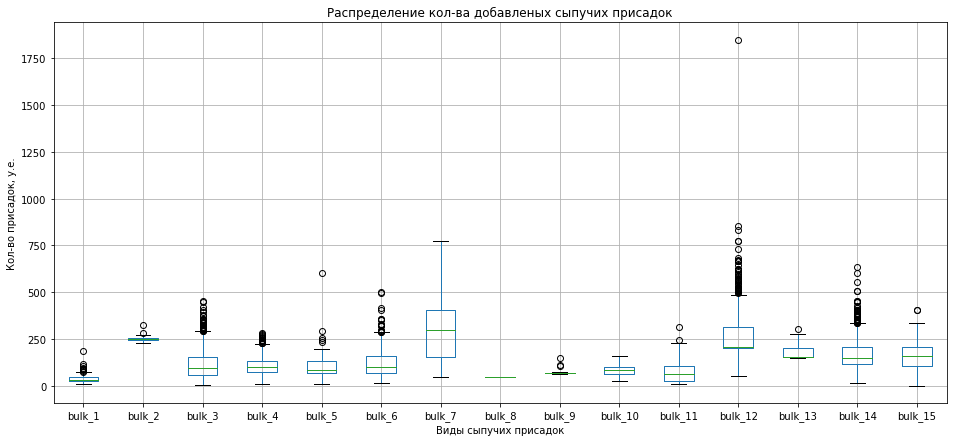

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [7]:
# анализ использования сыпучих присадок
bulk.loc[:, 'bulk_1':'bulk_15'].boxplot(figsize=(16, 7))
plt.title('Распределение кол-ва добавленных сыпучих присадок')
plt.ylabel('Кол-во присадок, у.е.')
plt.xlabel('Виды сыпучих присадок')
plt.show()

bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN
1747,1808,NaN,NaN,226.0,30.0,603.0,NaN,NaN,NaN,NaN,NaN,NaN,210.0,NaN,99.0,104.0


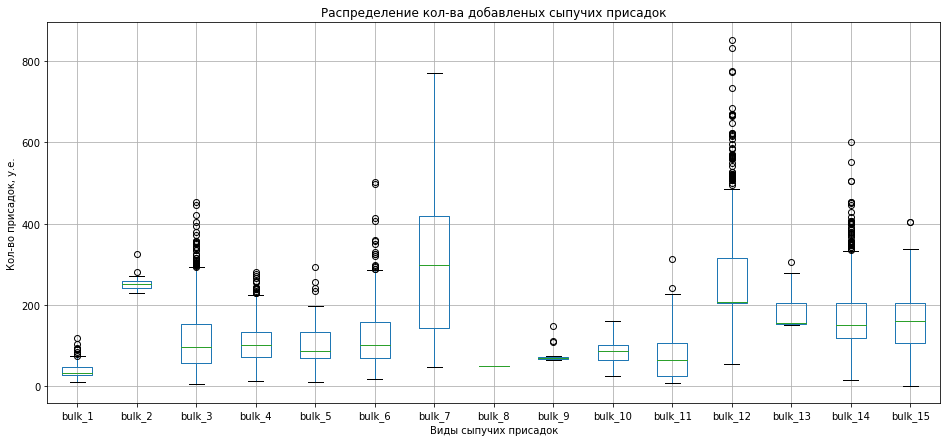

In [8]:
# аномальные партии (нетипично большие подачи сыпучих добавок №№ 5, 12)
anomaly_keys = bulk.loc[(bulk['bulk_5']>600) | (bulk['bulk_12']>1750), 'key'].values
display(bulk[bulk['key'].isin(anomaly_keys)])

bulk.drop(index=bulk[bulk['key'].isin(anomaly_keys)].index, inplace=True)
bulk_time.drop(index=bulk_time[bulk_time['key'].isin(anomaly_keys)].index, inplace=True)

bulk.loc[:, 'bulk_1':'bulk_15'].boxplot(figsize=(16, 7))
plt.title('Распределение кол-ва добавленных сыпучих присадок')
plt.ylabel('Кол-во присадок, у.е.')
plt.xlabel('Виды сыпучих присадок')
plt.show()

Присадка `bulk_8` - использовалась лишь однажды. На её основе не получится вывести закономерность использовать её.

In [9]:
# удаление неинформативных столбцов
bulk.drop('bulk_8', axis=1, inplace=True)
bulk_time.drop('bulk_8', axis=1, inplace=True)

# контроль
print(bulk.info())
print(bulk_time.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3127 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3127 non-null   int64  
 1   bulk_1   251 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1296 non-null   float64
 4   bulk_4   1012 non-null   float64
 5   bulk_5   76 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   24 non-null     float64
 8   bulk_9   19 non-null     float64
 9   bulk_10  176 non-null    float64
 10  bulk_11  177 non-null    float64
 11  bulk_12  2448 non-null   float64
 12  bulk_13  18 non-null     float64
 13  bulk_14  2804 non-null   float64
 14  bulk_15  2247 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 390.9 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3127 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----  

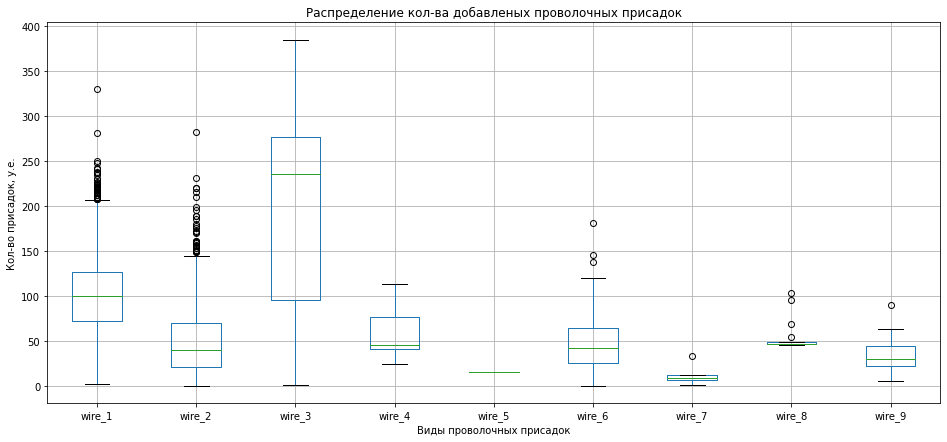

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [10]:
# анализ использования проволочных присадок
wire.loc[:, 'wire_1':'wire_9'].boxplot(figsize=(16, 7))
plt.title('Распределение кол-ва добавленных проволочных присадок')
plt.ylabel('Кол-во присадок, у.е.')
plt.xlabel('Виды проволочных присадок')
plt.show()

wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
901,961,55.177196,70.122002,NaN,NaN,NaN,NaN,NaN,NaN,90.053604
1201,1269,142.365600,282.780152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1392,1464,280.987214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1732,1821,330.314424,69.337838,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2102,2204,93.169434,NaN,NaN,NaN,NaN,180.454575,NaN,NaN,NaN
2436,2563,5.110560,NaN,93.165077,NaN,NaN,53.196003,32.847674,NaN,NaN


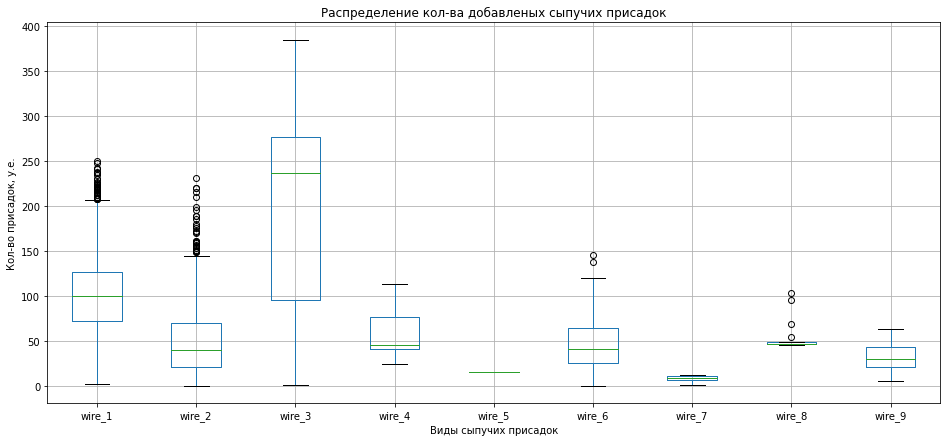

In [11]:
# аномальные партии (нетипично большие подачи сыпучих добавок №№ 5, 12)
anomaly_keys = wire.loc[(wire['wire_1']>270) | 
                        (wire['wire_2']>250) |
                        (wire['wire_6']>150) |
                        (wire['wire_7']>20) | 
                        (wire['wire_9']>75),
                        'key'].values
display(wire[wire['key'].isin(anomaly_keys)])

wire.drop(index=wire[wire['key'].isin(anomaly_keys)].index, inplace=True)
wire_time.drop(index=wire_time[wire_time['key'].isin(anomaly_keys)].index, inplace=True)

wire.loc[~wire['key'].isin(anomaly_keys), 'wire_1':'wire_9'].boxplot(figsize=(16, 7))
plt.title('Распределение кол-ва добавленных сыпучих присадок')
plt.ylabel('Кол-во присадок, у.е.')
plt.xlabel('Виды сыпучих присадок')
plt.show()

Присадка `wire_5` - использовалась лишь однажды. На её основе не получится вывести закономерность использовать её.

In [12]:
# удаление неинформативных столбцов
wire.drop('wire_5', axis=1, inplace=True)
wire_time.drop('wire_5', axis=1, inplace=True)

# контроль
print(wire.info())
print(wire_time.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3075 non-null   int64  
 1   wire_1  3049 non-null   float64
 2   wire_2  1076 non-null   float64
 3   wire_3  62 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_6  71 non-null     float64
 6   wire_7  10 non-null     float64
 7   wire_8  19 non-null     float64
 8   wire_9  28 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 240.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3075 non-null   int64         
 1   wire_1  3049 non-null   datetime64[ns]
 2   wire_2  1076 non-null   datetime64[ns]
 3   wire_3  62 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_6  71 

**Вывод:**
На данном этапе исходные данные сохранены в отдельный обработанные датафремы:
- названия столбцов переведены на английский язык и переименованы в формате _змеиный_регистр_;
- каждому столбцу назначен соответствующий тип данных;
- удалены неинформативные столбцы;
- пропуски обработаны;
- дубликаты отсутствуют.

*пропуски в датафреймах `bulk`, `bulk_time`, `wire` и `wire_time` будут заполнены отдельно по завершению анализа данных, дабы "заглушки" не могли помешать.

___

<a id='section_3'></a>
## Анализ данных (EDA)

<a id='section_3A'></a>
### Временной период

Весь процесс выплавки сопровождается контролем за температурой стали. По этой причине временной период будет определён на основе данных из датафрейма `temp`.

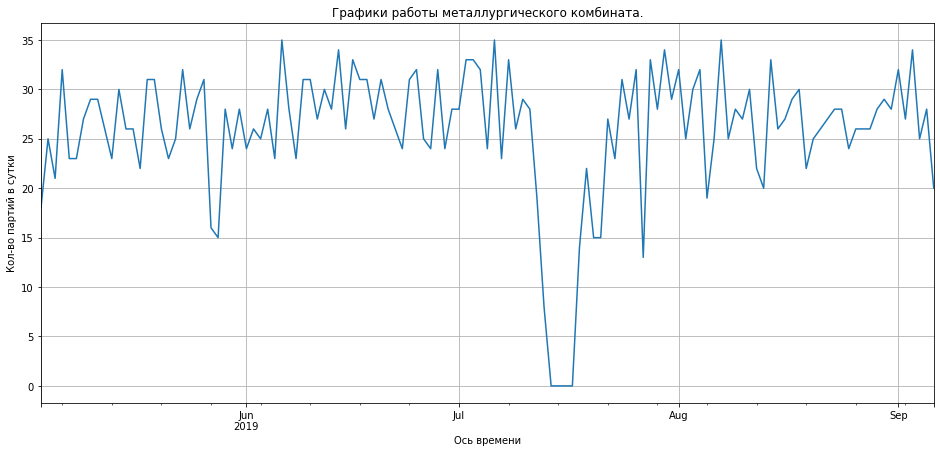

Исходные данные за период: 2019-05-03 - 2019-09-06 в формате ГГГГ-ММ-ДД.
Временной перерыв 14-18 июля 2019:


,key,time,temp


[пустой датафрейм]


In [13]:
# визуализация временного ряда
temp_resample = temp.set_index('time')['key'].resample('1D').nunique()
temp_resample.plot(figsize=(16, 7), grid=True)
plt.title('Графики работы металлургического комбината.')
plt.ylabel('Кол-во партий в сутки')
plt.xlabel('Ось времени')
plt.show()

print('Исходные данные за период:', temp['time'].dt.date.min(), '-', temp['time'].dt.date.max(), 'в формате ГГГГ-ММ-ДД.')

print('Временной перерыв 14-18 июля 2019:')
display(temp[(temp['time']>='2019-07-14') & (temp['time']<='2019-07-18')])
print('[пустой датафрейм]')

<a id='section_3B'></a>
### Время нагрева

In [14]:
# вычисление продолжительности времени нагрева
arc['heating_time'] = (arc['heating_end'] - arc['heating_start']).dt.seconds
display(arc.head())

,key,heating_start,heating_end,active_power,reactive_power,heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148


In [15]:
# сводная таблица партий с данными о нагревах каждой партии стали
heating = arc.groupby('key').agg({'heating_start' : ['min', 'max'],
                                  'heating_time'  : ['count', 'sum'],
                                  'active_power'  : ['sum'],
                                  'reactive_power': ['sum']})

heating.columns = ['first', 'last', 'heating_count', 'total_time', 'total_active_power', 'total_reactive_power']

display(heating)

,first,last,heating_count,total_time,total_active_power,total_reactive_power
key,,,,,,
1,2019-05-03 11:02:14,2019-05-03 11:26:09,5,1098,3.036730,2.142821
2,2019-05-03 11:34:14,2019-05-03 11:49:48,4,811,2.139408,1.453357
3,2019-05-03 12:06:54,2019-05-03 12:31:14,5,655,4.063641,2.937457
4,2019-05-03 12:39:37,2019-05-03 12:53:12,4,741,2.706489,2.056992
5,2019-05-03 13:11:13,2019-05-03 13:32:44,4,869,2.252950,1.687991
...,...,...,...,...,...,...
3237,2019-09-06 11:31:25,2019-09-06 11:51:39,5,909,2.541872,2.025417
3238,2019-09-06 12:16:25,2019-09-06 12:28:45,3,546,1.374821,1.038103
3239,2019-09-06 14:17:00,2019-09-06 15:03:45,8,1216,4.848005,3.541541


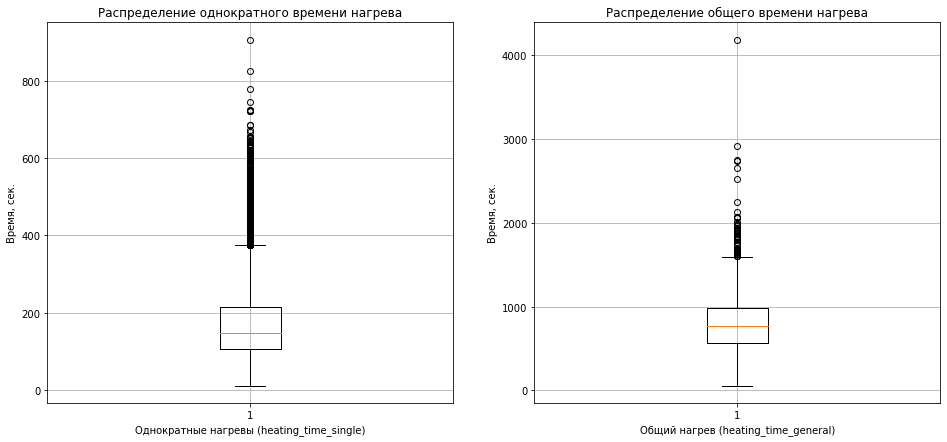

,heating_time,total_time
count,14876.000000,3214.000000
mean,171.670946,794.579029
std,98.186803,332.448622
min,11.000000,57.000000
25%,107.000000,571.000000
50%,147.000000,770.000000
75%,214.000000,983.000000
max,907.000000,4189.000000


In [16]:
# анализ продолжительности нагрева
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

axs[0].boxplot(arc['heating_time'])
axs[0].set_title('Распределение однократного времени нагрева')
axs[0].set_xlabel('Однократные нагревы (heating_time_single)')
axs[0].set_ylabel('Время, сек.')
axs[0].grid()

axs[1].boxplot(heating['total_time'])
axs[1].set_title('Распределение общего времени нагрева')
axs[1].set_xlabel('Общий нагрев (heating_time_general)')
axs[1].set_ylabel('Время, сек.')
axs[1].grid()
plt.show()

arc['heating_time'].describe().to_frame().join(heating['total_time'].to_frame().describe(),
                                               lsuffix='_single',
                                               rsuffix='_general')

In [17]:
# аномальная партия (общее время нагрева больше 4000 сек.)
anomaly_keys = heating.sort_values(by='total_time', ascending=False).head(1).index
display(arc[arc['key'].isin(anomaly_keys)])
arc.drop(anomaly_keys, inplace=True)

,key,heating_start,heating_end,active_power,reactive_power,heating_time
7793,1689,2019-07-05 08:07:21,2019-07-05 08:08:58,0.428776,0.362902,97
7794,1689,2019-07-05 08:12:06,2019-07-05 08:17:28,0.947266,0.733328,322
7795,1689,2019-07-05 08:20:53,2019-07-05 08:25:36,0.807232,0.510813,283
7796,1689,2019-07-05 08:32:51,2019-07-05 08:36:06,0.656772,0.441245,195
7797,1689,2019-07-05 08:41:00,2019-07-05 08:43:17,0.729808,0.596656,137
7798,1689,2019-07-05 11:23:07,2019-07-05 11:28:12,0.576072,0.378107,305
7799,1689,2019-07-05 11:30:50,2019-07-05 11:45:57,0.966775,0.675200,907
7800,1689,2019-07-05 12:39:20,2019-07-05 12:50:18,1.096739,0.728982,658
7801,1689,2019-07-05 12:51:41,2019-07-05 13:01:49,0.969873,0.691339,608
7802,1689,2019-07-05 14:05:14,2019-07-05 14:07:19,0.889432,0.556732,125


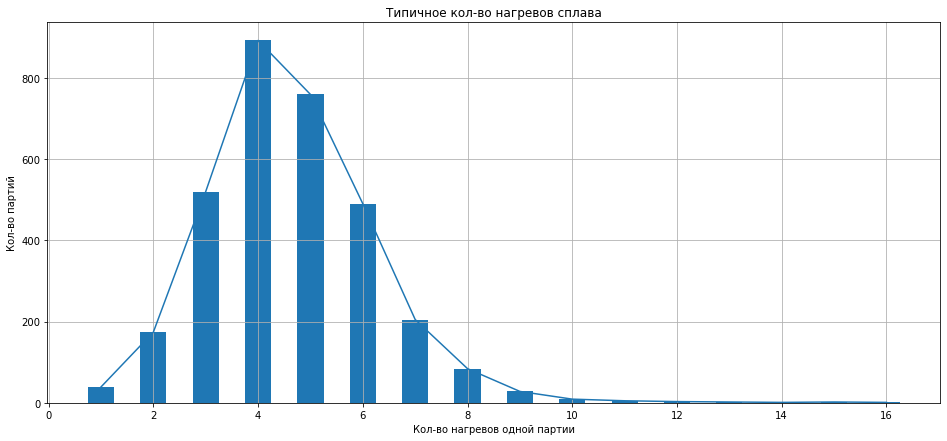

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
heating_count,39,174,520,892,759,490,205,84,28,9,5,3,2,1,2,1


In [18]:
# анализ кол-ва нагревов партии
heating['heating_count'].hist(bins=31, figsize=(16, 7), range=(0.75, 16.25))
heating['heating_count'].value_counts().sort_index().plot(grid=True, color='#1F77B4')
plt.title('Типичное кол-во нагревов сплава')
plt.xlabel('Кол-во нагревов одной партии')
plt.ylabel('Кол-во партий')
plt.show()

display(heating['heating_count'].value_counts().sort_index().to_frame().T)

<a id='section_3C'></a>
### Мощность нагрева (активная и реактивная)

In [19]:
# аномалии реактивной мощности
print('Наличие аномалий ДО:')
display(arc[arc['reactive_power']<0])
arc.drop(arc[arc['reactive_power']<0].index, inplace=True)
heating.drop(heating[heating['total_reactive_power']<0].index, inplace=True)

# контроль
print('Наличие аномалий ПОСЛЕ:')
display(arc[arc['reactive_power']<0])
print('[пустой датафрейм]')

Наличие аномалий ДО:


,key,heating_start,heating_end,active_power,reactive_power,heating_time
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924,109


Наличие аномалий ПОСЛЕ:


,key,heating_start,heating_end,active_power,reactive_power,heating_time


[пустой датафрейм]


In [20]:
# контроль неэффективной работы
print('Активная мощность меньше реактивной:')
display(arc[arc['active_power'] < arc['reactive_power']])
print('[пустой датафрейм]')

Активная мощность меньше реактивной:


,key,heating_start,heating_end,active_power,reactive_power,heating_time


[пустой датафрейм]


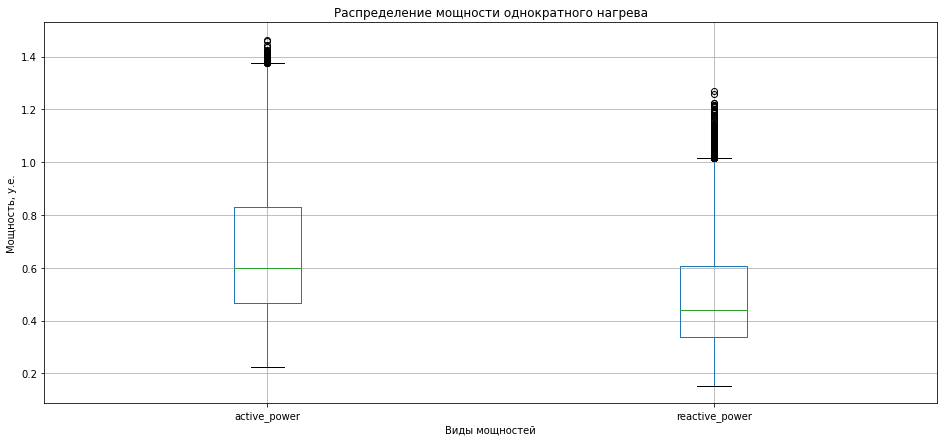

,active_power,reactive_power
count,14874.000000,14874.000000
mean,0.662760,0.487125
std,0.258899,0.197616
min,0.223120,0.153777
25%,0.467115,0.337187
50%,0.599587,0.441667
75%,0.830201,0.608245
max,1.463773,1.270284


In [21]:
# распределение значений мощности
arc.loc[:, 'active_power':'reactive_power'].boxplot(figsize=(16, 7))
plt.title('Распределение мощности однократного нагрева')
plt.ylabel('Мощность, у.е.')
plt.xlabel('Виды мощностей')
plt.show()

arc.loc[:, 'active_power':'reactive_power'].describe()

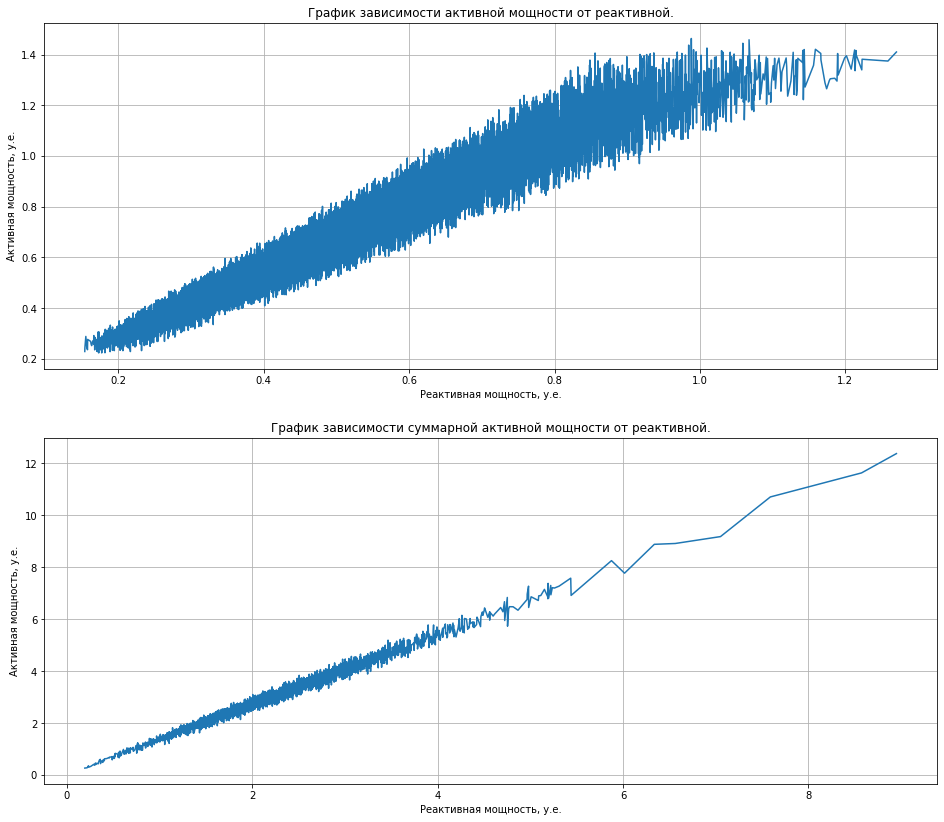

In [22]:
# анализ энергии нагрева
fig, axs = plt.subplots(2, 1, figsize=(16, 14))

axs[0].plot(arc.sort_values('reactive_power')['reactive_power'],
            arc.sort_values('reactive_power')['active_power'])
axs[0].set_title('График зависимости активной мощности от реактивной.')
axs[0].set_xlabel('Реактивная мощность, у.е.')
axs[0].set_ylabel('Активная мощность, у.е.')
axs[0].grid()

axs[1].plot(heating.sort_values('total_reactive_power')['total_reactive_power'],
            heating.sort_values('total_reactive_power')['total_active_power'])
axs[1].set_title('График зависимости суммарной активной мощности от реактивной.')
axs[1].set_xlabel('Реактивная мощность, у.е.')
axs[1].set_ylabel('Активная мощность, у.е.')
axs[1].grid()
plt.show()

<a id='section_3D'></a>
### Температура сплава

In [23]:
# аномальные партии с низкими начальными температурами
anomaly_keys = temp.loc[temp['temp']<1250, 'key'].values
display(temp[temp['key'].isin(anomaly_keys)])
print('Кол-во аномальных партий:', len(anomaly_keys))
temp.drop(index=temp[temp['key'].isin(anomaly_keys)].index, inplace=True)

,key,time,temp
4883,867,2019-06-06 08:03:39,1191
4884,867,2019-06-06 08:18:52,1575
4885,867,2019-06-06 08:22:38,1576
4886,867,2019-06-06 08:25:11,1571
4887,867,2019-06-06 08:29:49,1600
4888,867,2019-06-06 08:36:49,1522
4889,867,2019-06-06 08:43:02,1521
4890,867,2019-06-06 08:48:23,1599
6784,1214,2019-06-18 08:01:03,1208
6785,1214,2019-06-18 08:17:56,1608


Кол-во аномальных партий: 5


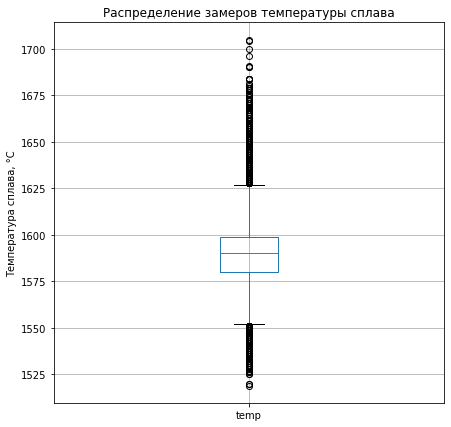

,temp
count,14643.000000
mean,1590.865055
std,19.122102
min,1519.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000


In [24]:
# распределение температуры
temp.boxplot('temp', figsize=(7, 7))
plt.title('Распределение замеров температуры сплава')
plt.ylabel('Температура сплава, °C')
plt.show()

display(temp['temp'].describe().to_frame())

<a id='section_3E'></a>
### Инертный газ

In [25]:
# аномальные партии с нетипично большим кол-ом прокаченного газа
anomaly_keys = gas.loc[gas['gas']>60, 'key'].values
display(gas[gas['key'].isin(anomaly_keys)])
print('Кол-во аномальных партий:', len(anomaly_keys))
gas.drop(index=gas[gas['key'].isin(anomaly_keys)].index, inplace=True)

,key,gas
277,280,60.935689
319,322,77.995040


Кол-во аномальных партий: 2


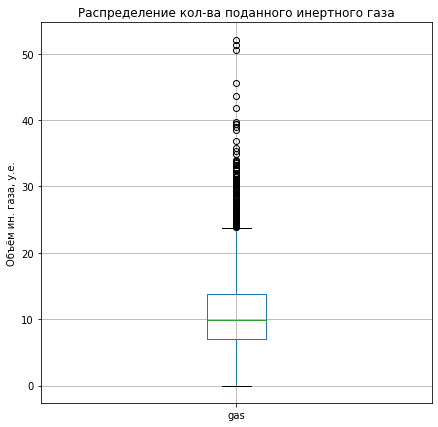

,gas
count,3237.000000
mean,10.965940
std,6.046293
min,0.008399
25%,7.042268
50%,9.828795
75%,13.767550
max,52.142373


In [26]:
# распределение кол-ва ин.газа
gas.boxplot('gas', figsize=(7, 7))
plt.title('Распределение кол-ва поданного инертного газа')
plt.ylabel('Объём ин. газа, у.е.')
plt.show()

gas['gas'].describe().to_frame()

**Вывод по анализу данных:**

Исходные данные получены за период **3 мая - 6 сентября 2019** года. В течение этого времени комбинат в среднем выпускал 20-30 партий стали в сутки, за исключением 14-18 июля 2019. Либо данные за этот период утеряны.

В датафрейм `arc` добавлен столбец `heating_time`, содержащий время нагрева в секундах. Так же была выявлена и удалена аномальная реактивная мощность (-715,5 у.е.). Её значение было отрицательное, а модуль отличался от других значений на порядки. Активная мощность, преимущественно, больше чем реактивная. Значения распределены нормально, но со смещением в бóльшую сторону.

В датафрейм `temp` были выявлены и удалены аномальные партии с низкими начальными температурами (1250 °C и ниже). Подавляющее большинство других партий поддерживают при температуре 1500 - 1700 °C. Распределение температуры сплава крайне похоже на _нормальное распределение_, смещение отсутствует. Присутствуют статистические выбросы.

В датафрейм `gas` были выявлены и удалены аномальные партии с чрезвычайно большим кол-ом прокаченного инертного газа через сплав. Присутствуют выбросы бóльших значений.

*аномальные партии были удалены только из датафреймов, в которых они были обнаружены. В других датафреймах, информация об этих партиях будет удалена автоматически при объединении датафреймов в общую выборку для предсказаний.

___

<a id='section_4'></a>
## Формирование (обуч. + тест.) выборок данных

<a id='section_4A'></a>
### Создание новых признаков

In [27]:
# сводная таблица партий с данными о температуре (нач. и кон.) и времени её замера
time_first_last = temp.groupby('key')['time'].min().to_frame().join(temp.groupby('key')['time'].max().to_frame(),
                                                                    lsuffix='_first',
                                                                    rsuffix='_last')
time_first_last['delta_time'] = (time_first_last['time_last'] - time_first_last['time_first']).dt.seconds


temp_first_last = temp.groupby('key')['temp'].first().to_frame().join(temp.groupby('key')['temp'].last().to_frame(),
                                                                      lsuffix='_first',
                                                                      rsuffix='_last')
temp_first_last['delta_temp'] = temp_first_last['temp_last'] - temp_first_last['temp_first']
temp_first_last['temp_count'] = temp.groupby('key')['temp'].count()

temp_key = time_first_last.join(temp_first_last)
display(temp_key)

,time_first,time_last,delta_time,temp_first,temp_last,delta_temp,temp_count
key,,,,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1714,1571,1613,42,6
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1265,1581,1602,21,5
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1753,1596,1599,3,6
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1220,1601,1625,24,5
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1536,1576,1602,26,5
...,...,...,...,...,...,...,...
3237,2019-09-06 11:31:15,2019-09-06 11:31:15,0,1569,1569,0,1
3238,2019-09-06 12:16:15,2019-09-06 12:16:15,0,1584,1584,0,1
3239,2019-09-06 14:16:50,2019-09-06 14:16:50,0,1598,1598,0,1


In [29]:
# 740 партий с одним лишь замером температуры (может быть использовать в качестве тестовой выборки?)
single_keys = temp_key[temp_key['temp_count'] <= 1].index
temp_key.loc[single_keys]
temp_key.drop(index=single_keys, inplace=True)

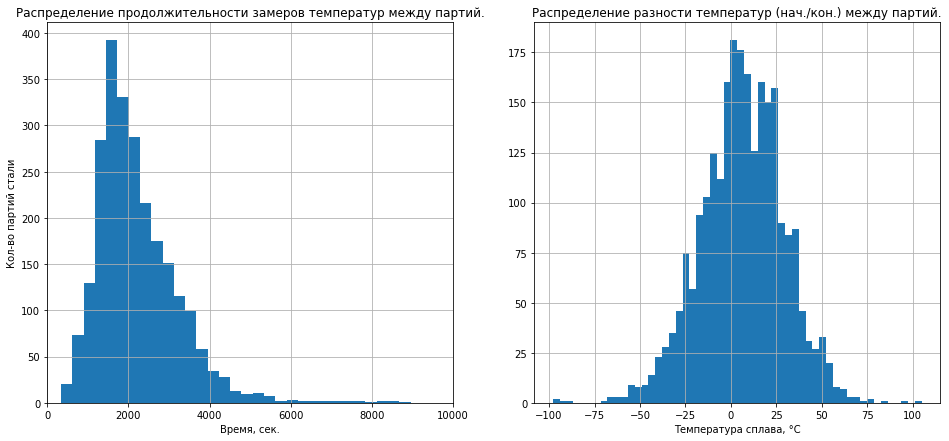

In [30]:
# анализ индивидуальной температуры сплава
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

axs[0].hist(temp_key['delta_time'], bins=84)
axs[0].set_title('Распределение продолжительности замеров температур между партий.')
axs[0].set_ylabel('Кол-во партий стали')
axs[0].set_xlabel('Время, сек.')
axs[0].set_xlim(0, 10000)
axs[0].grid()

axs[1].hist(temp_key['delta_temp'], bins=54)
axs[1].set_title('Распределение разности температур (нач./кон.) между партий.')
axs[0].set_ylabel('Кол-во партий стали')
axs[1].set_xlabel('Температура сплава, °C')
axs[1].grid()
plt.show()

In [31]:
# дополнение таблицы `bulk` с данными о добавленных СЫПУЧИХ присадок
bulk['bulk_count'] = bulk.loc[:, 'bulk_1':'bulk_15'].count(axis=1)
bulk['bulk_sum']   = bulk.loc[:, 'bulk_1':'bulk_15'].sum(axis=1)

display(bulk.head())

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_count,bulk_sum
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,4,553.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,4,582.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,4,544.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,4,595.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,4,584.0


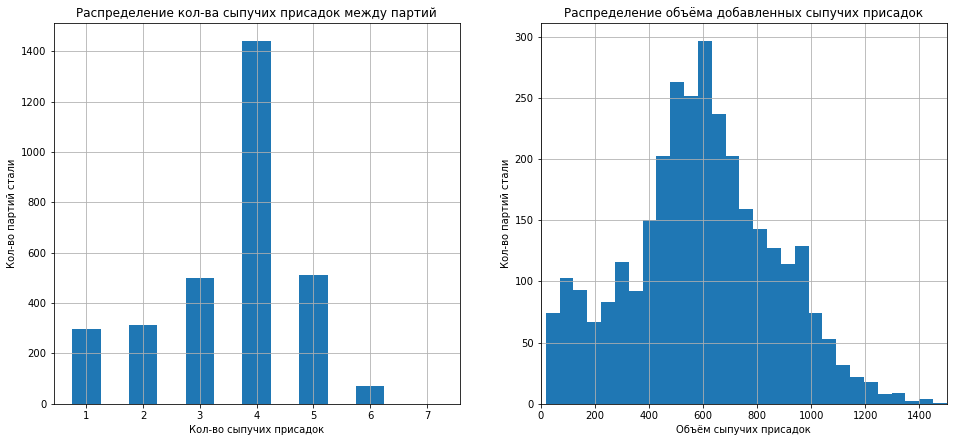

In [32]:
# анализ СЫПУЧИХ присадок
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

axs[0].hist(bulk['bulk_count'], bins=13, range=(0.75, 7.25))
axs[0].set_title('Распределение кол-ва сыпучих присадок между партий')
axs[0].set_ylabel('Кол-во партий стали')
axs[0].set_xlabel('Кол-во сыпучих присадок')
axs[0].grid()

axs[1].hist(bulk['bulk_sum'], bins=34)
axs[1].set_title('Распределение объёма добавленных сыпучих присадок')
axs[1].set_ylabel('Кол-во партий стали')
axs[1].set_xlabel('Объём сыпучих присадок')
axs[1].set_xlim(0, 1500)
axs[1].grid()
plt.show()

In [33]:
# Уникальная партия с большим кол-ом сыпучих присадок (встречаются в единственном экземпляре)
display(bulk[bulk['bulk_count'] >= 7])
bulk.drop(bulk[bulk['bulk_count'] >= 7].index, inplace=True)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_count,bulk_sum
1699,1759,46.0,NaN,212.0,NaN,33.0,121.0,NaN,NaN,NaN,NaN,410.0,NaN,251.0,205.0,7,1278.0


In [34]:
# дополнение таблицы `wire` с данными о добавленных ПРОВОЛОЧНЫХ присадок
wire['wire_count'] = wire.loc[:, 'wire_1':'wire_9'].count(axis=1)
wire['wire_sum']   = wire.loc[:, 'wire_1':'wire_9'].sum(axis=1)

display(wire.head())

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_count,wire_sum
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,60.059998
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,96.052315
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,91.160157
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,89.063515
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,2,98.352796


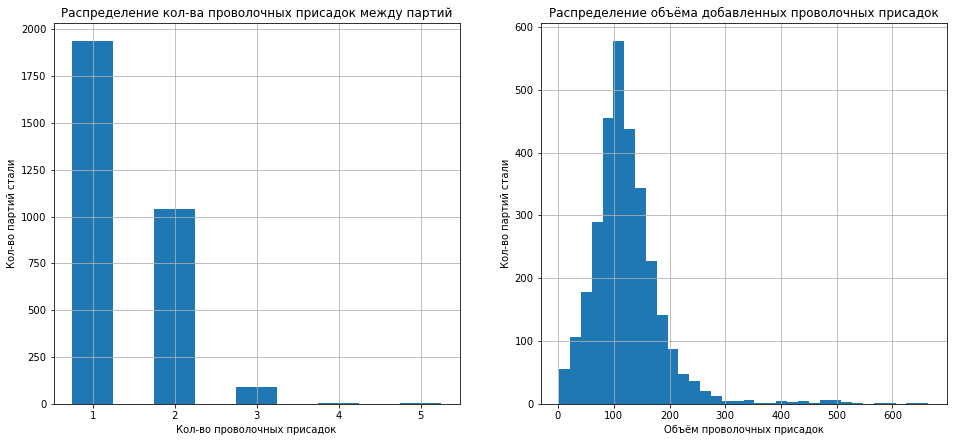

In [35]:
# анализ ПРОВОЛОЧНЫХ присадок
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

axs[0].hist(wire['wire_count'], bins=9, range=(0.75, 5.25))
axs[0].set_title('Распределение кол-ва проволочных присадок между партий')
axs[0].set_ylabel('Кол-во партий стали')
axs[0].set_xlabel('Кол-во проволочных присадок')
axs[0].grid()

axs[1].hist(wire['wire_sum'], bins=34)
axs[1].set_title('Распределение объёма добавленных проволочных присадок')
axs[1].set_ylabel('Кол-во партий стали')
axs[1].set_xlabel('Объём проволочных присадок')
axs[1].grid()
plt.show()

In [36]:
# Нетипичные партии с большим кол-ом проволочных присадок
display(wire[wire['wire_count'] >= 4])

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_count,wire_sum
97,113,7.55664,NaN,96.047951,24.148801,60.094322,NaN,NaN,NaN,4,187.847714
2006,2104,4.01856,NaN,90.138054,40.069122,78.078002,NaN,NaN,NaN,4,212.303738
2008,2106,4.06224,NaN,95.375282,113.231044,68.434087,5.035472,NaN,NaN,5,286.138125
2009,2107,9.08544,NaN,93.165077,82.150638,99.219122,8.490040,NaN,NaN,5,292.110317
2010,2108,11.05104,NaN,93.213127,92.570401,63.045845,1.053936,NaN,NaN,5,260.934349
2011,2109,7.03248,NaN,93.117027,43.244242,73.170247,NaN,NaN,NaN,4,216.563996
2012,2110,3.10128,NaN,93.165077,56.078880,91.428487,0.234208,NaN,NaN,5,244.007932
2435,2562,18.43296,NaN,96.096001,43.020641,67.438800,11.417641,NaN,NaN,5,236.406043
2437,2564,8.21184,NaN,94.126038,NaN,61.638725,12.354473,NaN,NaN,4,176.331076
2439,2566,2.09664,NaN,95.279190,47.224323,3.020157,9.134113,NaN,NaN,5,156.754423


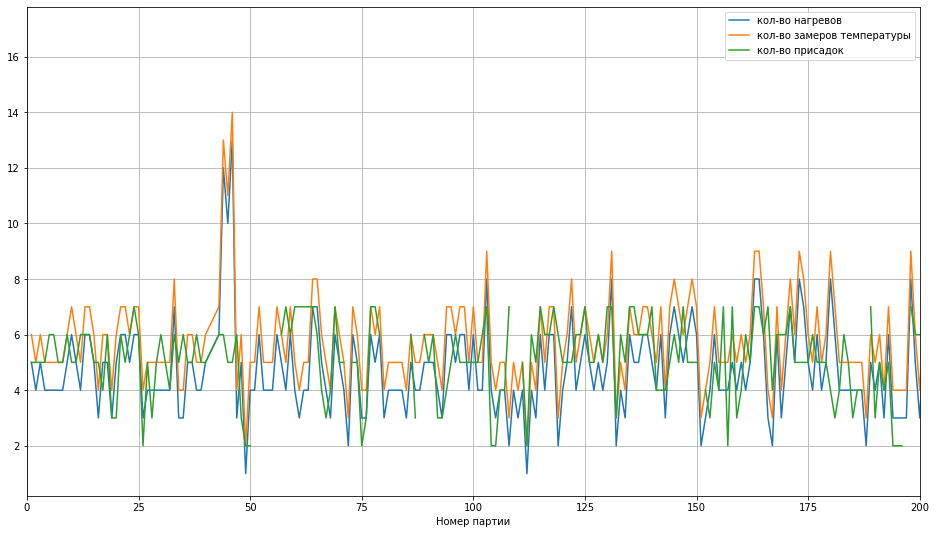

,кол-во нагревов,кол-во замеров температуры,bulk_count,wire_count,кол-во присадок
key,,,,,
1,5,6.0,4.0,1.0,5
2,4,5.0,4.0,1.0,5
3,5,6.0,4.0,1.0,5
4,4,5.0,4.0,1.0,5
5,4,5.0,4.0,2.0,6


In [37]:
# кол-во нагревов и замеров температуры
heating_n_temp = heating['heating_count'].to_frame().join(temp_key['temp_count'].to_frame()) 

# кол-во сыпучих и проволочных присадок
additive = bulk.set_index('key')['bulk_count'].to_frame().join(wire.set_index('key')['wire_count'].to_frame())
additive['additive_total'] = additive['bulk_count'] + additive['wire_count'].astype('Int64')

# объединение данных
heat_temp_add = heating_n_temp.join(additive)
heat_temp_add.rename(columns={'heating_count':'кол-во нагревов',
                              'temp_count':'кол-во замеров температуры',
                              'additive_total':'кол-во присадок'}, inplace=True)

heat_temp_add[['кол-во нагревов', 'кол-во замеров температуры', 'кол-во присадок']].plot(figsize=(16, 9), grid=True)
plt.xlabel('Номер партии')
plt.xlim(0, 200)
plt.show()

display(heat_temp_add.head())

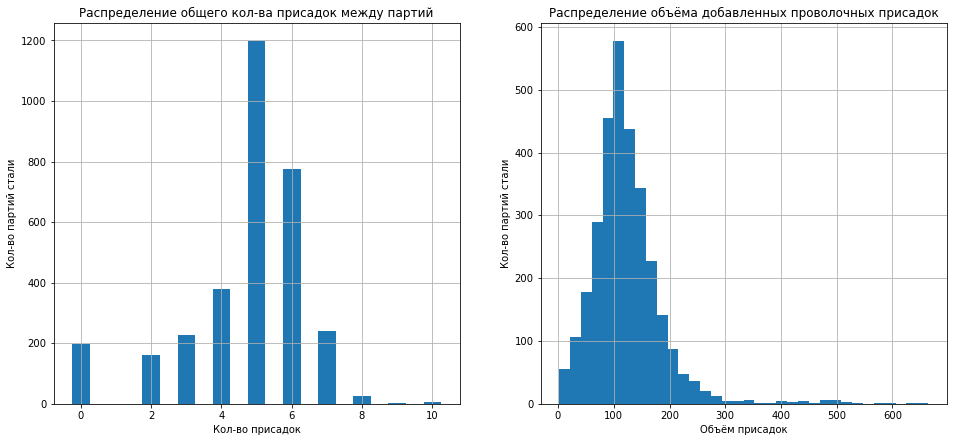

In [38]:
# анализ ПРОВОЛОЧНЫХ присадок
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

axs[0].hist(heat_temp_add.fillna(0)['кол-во присадок'], bins=21, range=(-0.25, 10.25))
axs[0].set_title('Распределение общего кол-ва присадок между партий')
axs[0].set_ylabel('Кол-во партий стали')
axs[0].set_xlabel('Кол-во присадок')
axs[0].grid()

axs[1].hist(wire['wire_sum'], bins=34)
axs[1].set_title('Распределение объёма добавленных проволочных присадок')
axs[1].set_ylabel('Кол-во партий стали')
axs[1].set_xlabel('Объём присадок')
axs[1].grid()
plt.show()

___
<a id='section_4B'></a>
### Выделение признаков

В этом разделе будут отобраны только те партии для которых доступны все данные в полной мере: нагрев, замеры температуры, добавление присадок и продувка газом.

Возможные признаки:
- начальная температура
- общее время нагревов
- общая затраченная активная мощность
- количество и виды добавленных присадок
- объём поданного инертного газа

In [39]:
# заполнение пропусков
plug = datetime.strptime("00-01-01 00:00:00", "%y-%m-%d %H:%M:%S")

bulk.fillna(0, inplace=True)
bulk_time.fillna(plug, inplace=True)

wire.fillna(0, inplace=True)
wire_time.fillna(plug, inplace=True)

In [40]:
# создание выборки для обучения / объединение отобранных признаков
data = temp_key[['temp_first', 'temp_last']]
data = data.join(heating[['heating_count', 'total_time', 'total_active_power']], how='inner')
data = data.join(bulk.set_index('key').loc[:, 'bulk_1':'bulk_15'], how='inner')
data = data.join(wire.set_index('key').loc[:, 'wire_1':'wire_9'], how='inner')
data = data.join(gas.set_index('key'), how='inner')

display(data)

,temp_first,temp_last,heating_count,total_time,total_active_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,5,1098,3.036730,0.0,0.0,0.0,43.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1581,1602,4,811,2.139408,0.0,0.0,0.0,73.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596,1599,5,655,4.063641,0.0,0.0,0.0,34.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1601,1625,4,741,2.706489,0.0,0.0,0.0,81.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576,1602,4,869,2.252950,0.0,0.0,0.0,78.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570,1591,4,723,3.168133,0.0,0.0,21.0,0.0,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2496,1554,1591,6,940,4.174918,0.0,0.0,0.0,63.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2497,1571,1589,3,569,3.605239,0.0,0.0,0.0,85.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699


<a id='section_4C'></a>
### Анализ сформированной выборки

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2316 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temp_first          2316 non-null   int64  
 1   temp_last           2316 non-null   int64  
 2   heating_count       2316 non-null   int64  
 3   total_time          2316 non-null   int64  
 4   total_active_power  2316 non-null   float64
 5   bulk_1              2316 non-null   float64
 6   bulk_2              2316 non-null   float64
 7   bulk_3              2316 non-null   float64
 8   bulk_4              2316 non-null   float64
 9   bulk_5              2316 non-null   float64
 10  bulk_6              2316 non-null   float64
 11  bulk_7              2316 non-null   float64
 12  bulk_9              2316 non-null   float64
 13  bulk_10             2316 non-null   float64
 14  bulk_11             2316 non-null   float64
 15  bulk_12             2316 non-null   float64
 16  bulk_1

In [42]:
# корреляция с целевым признаком
data.corr().round(3)['temp_last'].sort_values(ascending=False)

temp_last             1.000
wire_1                0.321
temp_first            0.302
total_time            0.278
bulk_15               0.269
bulk_12               0.267
bulk_4                0.189
heating_count         0.179
total_active_power    0.175
bulk_14               0.113
bulk_10               0.062
gas                   0.052
bulk_13              -0.011
wire_8               -0.014
bulk_9               -0.019
wire_9               -0.028
bulk_5               -0.039
bulk_3               -0.040
wire_3               -0.048
bulk_2               -0.083
bulk_1               -0.090
wire_6               -0.098
bulk_11              -0.116
bulk_7               -0.124
wire_7               -0.138
wire_4               -0.160
bulk_6               -0.180
wire_2               -0.215
Name: temp_last, dtype: float64

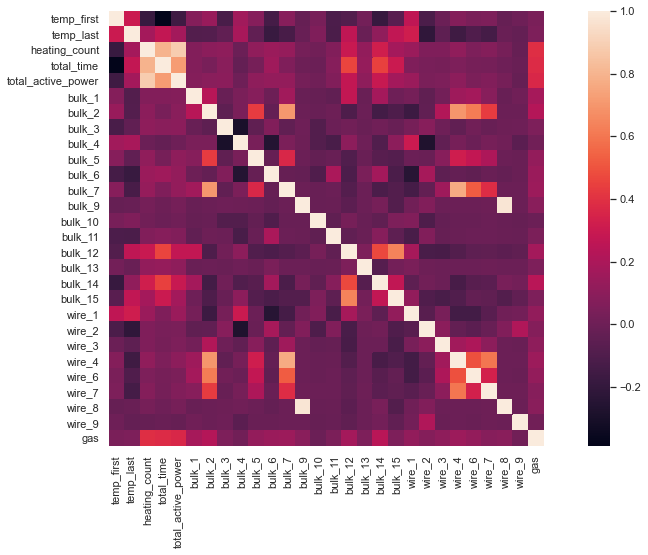

In [43]:
# матрица корреляций
sns.set(rc = {'figure.figsize':(16, 8)})
sns.heatmap(data.corr(), square=True);

In [44]:
# МультиКоллинеарность
y, X = dmatrices('temp_last ~ bulk_9+wire_8', data=data, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

display(vif)

,VIF,variable
0,1.004761,Intercept
1,19.349280,bulk_9
2,19.349280,wire_8


In [45]:
# анализ присадок "bulk_9" и "wire_8"
print('Перечень партий стали имеющие в составе присадку "bulk_9":\n', data[data['bulk_9']!=0].index)
print('Перечень партий стали имеющие в составе присадку "wire_8":\n', data[data['wire_8']!=0].index)
display(data.loc[data['bulk_9']!=0, ['bulk_9', 'wire_8']])

Перечень партий стали имеющие в составе присадку "bulk_9":
 Int64Index([281, 282, 283, 284, 285, 286, 287, 288, 289, 1786, 1975, 1976], dtype='int64', name='key')
Перечень партий стали имеющие в составе присадку "wire_8":
 Int64Index([281, 282, 283, 284, 285, 286, 287, 288, 289, 1786, 1975, 1976], dtype='int64', name='key')


,bulk_9,wire_8
key,,
281,68.0,46.094879
282,65.0,46.187439
283,71.0,46.094879
284,66.0,46.279999
285,70.0,46.187439
286,66.0,46.187439
287,70.0,45.354401
288,66.0,45.076721
289,65.0,45.076721


In [46]:
# удаление неинформативных столбцов (признаков)
data.drop(['wire_8', 'heating_count'], axis=1, inplace=True)

<a id='section_4D'></a>
### Валидация данных

Выборка данных будет разделена на две, согласно требованиям:
- Обучающая (75%)
- Тестовая (25%)

In [47]:
# выделение целевого признака
target = data['temp_last']
features = data.drop('temp_last', axis=1)

display(target.to_frame())
display(features)

,temp_last
key,
1,1613
2,1602
3,1599
4,1625
5,1602
...,...
2495,1591
2496,1591
2497,1589


,temp_first,total_time,total_active_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1098,3.036730,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,29.749986
2,1581,811,2.139408,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596,655,4.063641,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,28.554793
4,1601,741,2.706489,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576,869,2.252950,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570,723,3.168133,0.0,0.0,21.0,0.0,0.0,0.0,0.0,...,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,7.125735
2496,1554,940,4.174918,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,9.412616
2497,1571,569,3.605239,0.0,0.0,0.0,85.0,0.0,0.0,0.0,...,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,6.271699


In [48]:
# валидация
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.25,
                                                    random_state = RANDOM_STATE)

# контроль
print('Размер обучающей выборки: {} партий ({:.1%})'.format(len(X_train), len(X_train)/len(features)))
print('Размер тестовой выборки:  {} партий ({:.1%})'.format(len(X_test),  len(X_test)/len(features)))
print('Кол-во признаков-предсказателей:', X_test.shape[1])

Размер обучающей выборки: 1737 партий (75.0%)
Размер тестовой выборки:  579 партий (25.0%)
Кол-во признаков-предсказателей: 25


In [49]:
# масштабирование признаков (тестовый режим)
columns = ['temp_first', 'total_time', 'gas']

scaler = StandardScaler()
scaler.fit(X_train[columns])
X_train[columns] = scaler.transform(X_train[columns])
X_test[columns]  = scaler.transform(X_test[columns])

display(X_train)

,temp_first,total_time,total_active_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,
1752,-1.243140,1.445621,5.467457,0.0,0.0,83.0,0.0,0.0,0.0,0.0,...,348.0,203.0,91.166397,0.000000,0.0,0.0,0.0,0.0,0.0,0.876301
846,-0.016942,0.024473,2.937721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,152.0,0.0,118.310394,0.000000,0.0,0.0,0.0,0.0,0.0,-0.758286
1728,1.209256,0.356074,4.633091,0.0,0.0,181.0,0.0,0.0,0.0,0.0,...,207.0,198.0,126.313202,0.000000,0.0,0.0,0.0,0.0,0.0,0.459524
1256,-0.947161,0.057041,3.972544,0.0,0.0,0.0,51.0,142.0,0.0,0.0,...,143.0,0.0,145.126799,0.000000,0.0,0.0,0.0,0.0,0.0,-0.510705
1429,0.448167,0.512993,3.756809,0.0,0.0,0.0,116.0,0.0,0.0,0.0,...,112.0,100.0,100.105194,0.000000,0.0,0.0,0.0,0.0,0.0,-0.151711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0.321319,-0.360421,2.629662,0.0,0.0,0.0,66.0,0.0,0.0,0.0,...,130.0,203.0,105.019203,0.000000,0.0,0.0,0.0,0.0,0.0,-0.878588
206,-0.059225,-1.284167,2.876935,0.0,0.0,0.0,59.0,0.0,0.0,0.0,...,205.0,103.0,127.458237,15.113280,0.0,0.0,0.0,0.0,0.0,-0.576186
1572,-0.524335,0.554443,4.476954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,199.0,205.0,97.999199,78.174714,0.0,0.0,0.0,0.0,0.0,0.242635


**Вывод:** сформирована выборка данных `data`, которая будет применяться для обучения и теста моделей.
- общее число объектов: 2316;
- число признаков (вкл. целевой): 26;
- пропуски, дубликаты - отсутствуют.

Обнаружена и устранена зависимость: все партии стали, содержащие `bulk_9`, обязательно содержат `wire_8`, и на оборот. Объём добавленных присадок пропорционален друг другу.

**Подготовлены** две выборки:
- Тренировочная (75%)
- Тестовая (25%)

___

<a id='section_5'></a>
## Обучение модели

В этом разделе будут опробованы несколько моделей:
- Линейная регрессия (примитивная модель и быстрая модель)
- Решающее дерево (более сложная модель выискивающая закономерности)
- CatBoost (модель градиентного бустинга)

<a id='section_5A'></a>
### Линейная регрессия (LR)

In [50]:
model_LR = LinearRegression()
scores = abs(cross_val_score(model_LR, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))

print('Погрешность (MAE): ± {:.2f}°C'.format(scores.mean()))

Погрешность (MAE): ± 6.35°C


In [51]:
# вектор весов (w) / значимость признаков
model_LR.fit(X_train, y_train)
w = pd.DataFrame(data=model_LR.coef_, index=X_train.columns, columns=['w'])
display(w)

,w
temp_first,5.406060
total_time,7.146916
total_active_power,-1.093504
bulk_1,-0.122638
bulk_2,0.070905
bulk_3,-0.000921
bulk_4,0.004322
bulk_5,-0.013369
bulk_6,-0.026475
bulk_7,0.003129


<a id='section_5B'></a>
### Случайный лес (RF)

In [52]:
list_est = []
list_mae = []
mae_min = 30

for est in tqdm(range(10, 91, 10)):
    for depth in range(1, 11):
        model_RF = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=RANDOM_STATE)
        scores = abs(cross_val_score(model_RF, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
        if mae_min >= scores.mean():
            mae_min = scores.mean() 
            best_dep = depth
            best_est = est
            best_RF = model_RF
    list_est.append(est)
    list_mae.append(mae_min)

print('Минимальная погрешность (MAE): ± {:.2f}°C, при кол-ве деревьев: {}, и их глубине: {}'.format(mae_min,best_est,best_dep))

  0%|          | 0/9 [00:00<?, ?it/s]

Минимальная погрешность (MAE): ± 6.23°C, при кол-ве деревьев: 80, и их глубине: 9


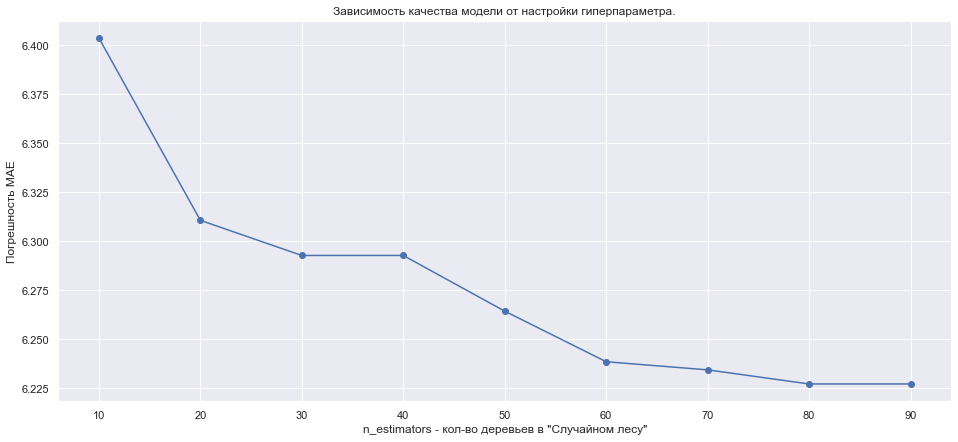

In [53]:
# Визуализация зависимости качества модели от изменения гиперпараметра
rmse_score_data = pd.DataFrame({'est': list_est, 'mae': list_mae})
rmse_score_data.plot(style='o-', x='est', y='mae', grid=True, legend=False, figsize=(16, 7),
                     title='Зависимость качества модели от настройки гиперпараметра.',
                     xlabel='n_estimators - кол-во деревьев в "Случайном лесу"',
                     ylabel='Погрешность MAE')
plt.show();

In [54]:
# значимость признаков
best_RF.fit(X_train, y_train)
w = pd.DataFrame(data=best_RF.feature_importances_, index=X_train.columns, columns=['w'])
display(w)

,w
temp_first,0.219657
total_time,0.232094
total_active_power,0.034387
bulk_1,0.014143
bulk_2,0.001960
bulk_3,0.017474
bulk_4,0.015587
bulk_5,0.002215
bulk_6,0.094318
bulk_7,0.025158


<a id='section_5C'></a>
### CatBoost (CB)

In [55]:
model_CB = CatBoostRegressor(learning_rate=0.04, verbose = 1000, loss_function = 'MAE', random_state=RANDOM_STATE)
scores = abs(cross_val_score(model_CB, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))

print('Погрешность (MAE): ± {:.2f}°C'.format(scores.mean()))

0:	learn: 7.8476016	total: 303ms	remaining: 5m 2s
999:	learn: 2.8471180	total: 5.49s	remaining: 0us
0:	learn: 7.9789479	total: 7.17ms	remaining: 7.17s
999:	learn: 2.9792181	total: 5.44s	remaining: 0us
0:	learn: 8.0274522	total: 6.59ms	remaining: 6.58s
999:	learn: 2.9817566	total: 5.11s	remaining: 0us
0:	learn: 7.9312796	total: 6.13ms	remaining: 6.12s
999:	learn: 3.0460409	total: 5.39s	remaining: 0us
0:	learn: 8.1569774	total: 6.34ms	remaining: 6.33s
999:	learn: 3.0794143	total: 5.31s	remaining: 0us
Погрешность (MAE): ± 6.11°C


In [56]:
# значимость признаков
model_CB.fit(X_train, y_train)
w = pd.DataFrame(data=model_CB.get_feature_importance(), index=X_train.columns, columns=['w'])
display(w)

0:	learn: 7.9765793	total: 6.94ms	remaining: 6.93s
999:	learn: 3.3065738	total: 5.72s	remaining: 0us


,w
temp_first,18.728337
total_time,22.246129
total_active_power,5.182185
bulk_1,2.668645
bulk_2,0.183682
bulk_3,3.094144
bulk_4,2.807907
bulk_5,0.733033
bulk_6,6.322643
bulk_7,0.382284


<a id='section_5D'></a>
### Проверка моделей на адекватность

Ниже приведены оценки работы двух константных моделей:
- первая предсказываете среднее;
- вторая - медианное значение.

In [57]:
# Dummy-mean модель
dummy_mean = DummyRegressor('mean')
dummy_mean.fit(X_train, y_train)
dummy_prediction = dummy_mean.predict(X_train)
mae_score = mean_absolute_error(y_train, dummy_prediction)

print('Погрешность (MAE): ± {:.2f}°C'.format(mae_score))

Погрешность (MAE): ± 8.12°C


In [58]:
# Dummy-mean модель
dummy_mean = DummyRegressor('median')
dummy_mean.fit(X_train, y_train)
dummy_prediction = dummy_mean.predict(X_train)
mae_score = mean_absolute_error(y_train, dummy_prediction)

print('Погрешность (MAE): ± {:.2f}°C'.format(mae_score))

Погрешность (MAE): ± 8.07°C


**Вывод:** Константные модели (`mean` и `median`) делают предсказания схожего качества. Очевидно, что опробованные ранее модели делают предсказания точнее, нежели константная.

- **Линейная регрессия** - быстро обучается, быстро предсказывает, но имеет наивысшую погрешность ± 6.35°C, относительно остальных.
- **Случайный лес** - максимально долгое обучение из-за подбора гиперпараметров (3 минуты). Погрешность ± 6.23°C.
- **CatBoost** - более быстрое обучение, в сравнении с предыдущей моделью (~1 минута), и наименьшая погрешность ± 6.11°C.

___

<a id='section_6'></a>
## Итоговое тестирование

In [59]:
model = CatBoostRegressor(verbose = 200, loss_function = 'MAE', random_state=RANDOM_STATE)
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)
final_score = mean_absolute_error(y_test, prediction_test)

print('Погрешность (MAE): ± {:.2f}°C'.format(final_score))

0:	learn: 7.9995615	total: 7.67ms	remaining: 7.67s
200:	learn: 5.1461749	total: 1.21s	remaining: 4.81s
400:	learn: 4.4536086	total: 2.35s	remaining: 3.51s
600:	learn: 4.0098017	total: 3.5s	remaining: 2.32s
800:	learn: 3.7331553	total: 4.72s	remaining: 1.17s
999:	learn: 3.5396471	total: 5.83s	remaining: 0us
Погрешность (MAE): ± 5.98°C


___
<a id='section_7'></a>
## Итоговый вывод

Изначальная задача заключалась в предсказании **конечной температуры сплава** по завершению всего тех. процесса. Подразумевается, что к этому моменты сплав уже будет содержать необходимые присадки и подогрет до требуемой температуры.

Исходные данными были разгруппированы по тематическим датасетам, в том же виде, в котором они были предоставлены:
- `arc` — время и кол-во _нагревов_;
- `gas` — объём _инертного газа_ для продувки сплава;
- `temp` — замеры _температуры сплава_;
- `bulk`и `bulk_time` — объём _сыпучих легирующих присадок_ и время их подачи, соответственно;
- `wire`и `wire_time` — объём _проволочных легирующих присадок_ и время их подачи, соответственно.

*всем данным был назначен соответствующий тип (`int`, `float`, `datetime`) 

В исходных данных находилась около 3200 партий стали. Часть из них содержала не полную информацию (к примеру: отсутствовали данные о присадках, нагреве, продувке газа или замерах температуры сплава). Около 740 партий содержали информацию лишь об одном температурном замере. Единичные экземпляры (около 20 партий) содержала недостоверные/нетипичные данные, к примеру: _активная мощность_ = -715 у.е. 

Так же, анализ данных помог выявить неинформативность столбов `bulk_8` и `wire_5`, поскольку эти виды присадок использовались Несмотря на их физическое различие, состав вероятней всего одинаков. Из-за чего возникала корреляция между этими параметрами. В итоговую выборку данных `bulk_8`, `wire_5` и `wire_8`- не вошли.

Ключевая информация по **обучению моделей**:
- Обучающая выборка: 1737 объектов
- Тестовая выборка: 579 объекта
- Количество признаков-предсказателей: 25
- Перечень признаков:
    - начальная температура,
    - общее время нагревов,
    - общая затраченная активная мощность,
    - количество и виды добавленных присадок,
    - объём прокаченного инертного газа.

**Результаты обучения и тестирования:** наилучший результат продемонстрировала модель градиентного бустинга CatBoost.
- её погрешность предсказаний ± 6.11°C (на кросс-валидации _тренировочной выборки_) и ± 5.98°C (на _тестовой выборке_)
- среднее время обучение: около 1-ой минуты;
- время предсказаний крайне мало, мгновенное.

Для дальнейшего применения модели CatBoost, её точность можно повысить за счёт объединения обучающей и тестовой выборок, и предобучить модель на бóльшей выборке.

___

### Отчёт в формате требуемый заказчиком.

В процессе работы над проектом изначальный [план](#section_plan) дополнялся новыми пунктами и разделами, все из которых удалось выполнить: создать новые данные или проанализировать имеющиеся, сделать выводы и использовать полученную информацию в следующем разделе.

Возникали **затруднения** на этапе знакомства с данными ввиду большого количества параметров, часть из которых не была столь информативна, сколько занимала месте в исходных датасетах. К примеру: практически каждый параметр сопровождался штампом времени. Иногда это время дублировалось или имело крайне малую разницу между двумя техническими процессами. Этап знакомства с данными получился более продолжительный, чем ожидалось.

Вместе с исходными данными было бы полезно получить схематичное описание порядка сбора этих данных. Это помогло бы явно представить хронологию в данных и выявить взаимосвязь на раннем этапе. А так же некоторые справочные значения популярных сплавов, дабы иметь основание для оценки партии: "присутствует ли в данных ошибка или это особый тех. процесс?".
К примеру: является ли допустимой температура сплава 1200 - 1300°C ?

Из всего проекта хочется выделить несколько **ключевых этапов**:
- знакомство с данными. Это может показать очевидным и естественны, но на сколько полным будет понимание данных, на столько быстрее или подробней получится проработать все последующие этапы;
- выявление единичных или нетипичных партий из общего числа;
- оценка значимости подобранных параметров на практике;
- тестирование нескольких моделей разного типа (принципа работы);
- и на каждом этапе стоит контролировать наличие пропусков, аномалий и соответствие типа данных.

В итоговую выборку данных пошли следующие **признаки**:
- начальная температура из датасета `data_temp_new.csv` (пропуски и аномалии - удалены),
- общее время нагревов из датасета `data_arc_new.csv`  (штучная аномалия - удалена),
- общая затраченная активная мощность из того же источника `data_temp_new.csv` (штучная аномалия - удалена),
- количество и виды добавленных присадок из датасетов `data_bulk_new.csv` и `data_wire_new.csv` (пропуски заменены на нулевое значение),
- объём прокаченного инертного газа из датасета `data_gas_new.csv` (штучные аномалии - удалены).

*дублирование записей/партий - отсутствует.

**Итоговая модель:** CatBoost на основе стохастического градиентного бустинга (SGB), с функцией потерь МАЕ (mean_absolute_error). Шаг градиентного бустинга назначается автоматически (ориентировочное значение 0,04). Погрешность предсказаний ± 6.11°C (на кросс-валидации тренировочной выборки) и ± 5.98°C (на тестовой выборке).

**Перечень использованных программных элементов:**
- для чтения и работы с датасетами в формате `*.csv` использовалась библиотека [Pandas](https://pandas.pydata.org/pandas-docs/version/1.5/index.html);
- для обработки пропусков в _дате и времени_ использовалась одноимённый элемент из библиотеки [DateTime](https://docs.python.org/3/library/datetime.html);
- для графического представления данных и изображения зависимостей использовался раздел `pyplot` из библиотеки [MatPlotLib](https://matplotlib.org/stable/api/pyplot_summary.html);
- отдельно, для визуализации _матрицы корреляции_ использовалась функция `heatmap` из библиотеки [Seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap);

- для подготовки признаков и проверки мультиколлинеарности использовались элементы `dmatrices` из [patsy](https://patsy.readthedocs.io/en/latest/API-reference.html), и `variance_inflation_factor` из [statsmodels.stats.outliers_influence](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

- для валидации и масштабирования данных, а так же для формирования и оценки предсказаний использовались следующие элементы из библиотеки [Scikit-Learn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning):
    - `train_test_split, cross_val_score`,
    - `StandardScaler`,
    - `LinearRegression`,
    - `RandomForestRegressor`,
    - `DummyRegressor`,
    - `mean_absolute_error`.


- И отдельно, модель градиентного бустинга _CatBoostRegressor_ из библиотеки [catboost](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor).

Не обязательные элементы:
- для работы над проектом из нескольких директорий используется элементы библиотеки [os](https://docs.python.org/3/library/os.path.html);
- для отображения длительного процесса подбора гиперпараметров модели использовалась функция `tqdm` из раздела [tqdm.notebook](https://tqdm.github.io/docs/notebook/);
- для презентабельного оформления проекта технические сообщения были скрыты с помощью фильтра `filterwarnings("ignore")` из библиотеки [warnings](https://docs.python.org/3/library/warnings.html).

*подробный перечень библиотек и используемых элементов собран в отдельной ячейке в [начале проекта](#section_2A)
___

<a id='section_8'></a>
## Список вопросов для заказчика

После первоначального знакомства данных возник перечень уточняющих вопросов к TeamLeed'у и к заказчику.

1. Столбец `key` намекает, что в этом проекте потребуется использовать запросы `SQL`. Верно ли я предполагаю?
2. Есть ли документация для датасетов? Какие данные содержатся столбце таблицы?
3. В датасете `data_arc_new.csv` c данными об электродах, находятся столбцы `Активная мощность` и `Реактивная мощность`. Они содержат электрическую и тепловую мощность, соответственно?
4. В датасете `data_bulk_new.csv`, что подразумевается под названием `Bulk_1`, `Bulk_2` и т.д.? Это виды сыпучих легирующих присадок и их объём, добавленный в сплав?
5. В датасете `data_temp_new.csv`, столбец `Газ 1` - содержит **количество** поданного инертного газа для продувки сплава? Если существует столбец `Газ 1` существует ли столбец `Газ 2`, `Газ 3`, ... ?
6. В датасете `data_wire_new.csv`, что подразумевается под названием `Wire_1`, `Wire_2` и т.д.? Это виды проволочных легирующих присадок и их объём, добавленный в сплав?
7. Правильно ли я понял, что легирующие присадки могут быть в виде сыпучих материалов или проволоки?
8. Общее количество партий: 3129?
9. Целевой признак - это столбец `Температура` в таблице `data_temp_new.csv`, верно?
10. Какая метрика качества (MSE, SMAPE, R2 или др.)?

По всем вопросам получил ответ на прошедшем вебинаре. **Вопросов не осталось.**